In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection

1. Для реализованной модели построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

In [11]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            #train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
           # test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            #train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            #test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees#, train_errors, test_errors

In [12]:
n_trees = list(range(1, 151))
max_depth = list(range(1, 11))
eta = 0.01

In [13]:
error_list_n_trees_train = []
error_list_n_trees_test = []
for n in n_trees:
    coefs = [1]*n
    trees = gb_fit(n, 5, X_train, X_test, y_train, y_test, coefs, eta)
    error_list_n_trees_train.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
    error_list_n_trees_test.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

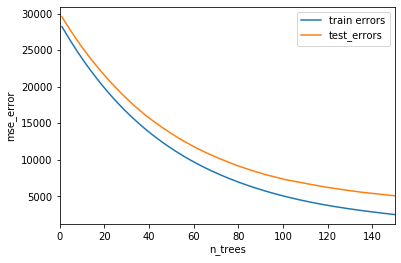

In [17]:
plt.xlabel('n_trees')
plt.ylabel('mse_error')
plt.xlim(0, n_trees[-1])
plt.plot(n_trees, error_list_n_trees_train, label='train errors')
plt.plot(n_trees, error_list_n_trees_test, label='test_errors')
plt.legend(loc='upper right')
plt.show()

In [18]:
%%time
error_list_max_depth_train = []
error_list_max_depth_test = []
for d in max_depth:
    coefs = [1]*20
    trees = gb_fit(20, d, X_train, X_test, y_train, y_test, coefs, eta)
    error_list_max_depth_train.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
    error_list_max_depth_test.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

Wall time: 25 s


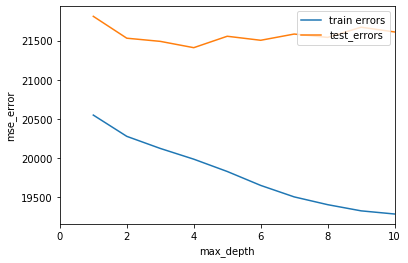

In [21]:
plt.xlabel('max_depth')
plt.ylabel('mse_error')
plt.xlim(0, max_depth[-1])
plt.plot(max_depth, error_list_max_depth_train, label='train errors')
plt.plot(max_depth, error_list_max_depth_test, label='test_errors')
plt.legend(loc='upper right')
plt.show()

В случае увеличения кол-ва деревьев в ансамбле мы видим монотонную зависимость в сторону уменьшения ошибки, однако здесь так же важно подобрать параметры максимальной глубины, коэффициента $\gamma$ и шага. В данном случае мы видим что алгоритм расходится. С максимально глубиной все не так однозначно и наилучшее качество достигается на уровне 4-6.

2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. 
    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [44]:
import random

In [62]:
def get_subsample(X, y, size=0.5):
    sample_size = int(X.shape[0]*size)
    indices = random.sample(range(X.shape[0]), sample_size)
    subsample_X = np.zeros((len(indices), X.shape[1]))
    subsample_y = np.zeros((len(indices),))
    for i, j in zip(indices, list(range(sample_size))):
        subsample_X[j] = X[i]
        subsample_y[j] = y[i]
    return subsample_X, subsample_y

In [58]:
def stochastic_gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    random.seed(42)
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            X_train_subsample, y_train_subsample = get_subsample(X_train, y_train)
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_subsample, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_subsample, bias(y_train_subsample, target))
            
            train_errors.append(mean_squared_error(y_train_subsample, gb_predict(X_train_subsample, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [65]:
coefs = [1]*100
trees_100, train_errors_100, test_errors_100 = stochastic_gb_fit(100, 5, X_train, X_test, y_train, y_test, coefs, eta)

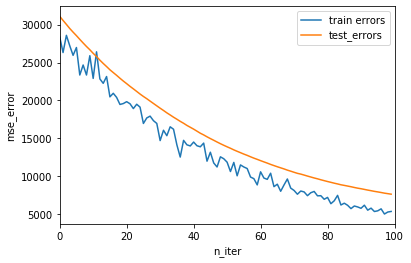

In [67]:
plt.xlabel('n_iter')
plt.ylabel('mse_error')
plt.xlim(0, 100)
plt.plot(list(range(len(train_errors_100))), train_errors_100, label='train errors')
plt.plot(list(range(len(test_errors_100))), test_errors_100, label='test_errors')
plt.legend(loc='upper right')
plt.show()